In [1]:
%load_ext rpy2.ipython
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import pdb
from sklearn.metrics import *

In [2]:
%%R 
library(ggplot2)

# Load dataset

In [3]:
genres_data = pd.read_csv(
    'movielens-dataset/u.genre', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names=['name', 'id']
)

In [4]:
movie_data_columns = np.append(
    ['movie_id', 'title', 'release_date', 'video_release_date', 'url'], 
    genres_data['name'].values
)

In [5]:
movie_data = pd.read_csv(
    'movielens-dataset/u.item', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names = movie_data_columns,
    index_col = 'movie_id'
)

In [6]:
selected_columns = np.append(['title', 'release_date'], genres_data['name'].values)
movie_data = movie_data[selected_columns]
movie_data['release_date'] = pd.to_datetime(movie_data['release_date'])

movie_data.head()

,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
ratings_data = pd.read_csv(
    'movielens-dataset/u.data', 
    sep = '\t', 
    encoding = "ISO-8859-1", 
    header = None, 
    names=['user_id', 'movie_id', 'rating', 'timestamp']
)

In [8]:
movie_data['ratings_average'] = ratings_data.groupby(['movie_id'])['rating'].mean()
movie_data['ratings_count'] = ratings_data.groupby(['movie_id'])['rating'].count()

In [9]:
movie_data[['title', 'ratings_average', 'ratings_count']].head()

,title,ratings_average,ratings_count
movie_id,,,
1,Toy Story (1995),3.878319,452
2,GoldenEye (1995),3.206107,131
3,Four Rooms (1995),3.033333,90
4,Get Shorty (1995),3.550239,209
5,Copycat (1995),3.302326,86


# Remove null values

In [10]:
movie_data[selected_columns].isnull().any()

title           False
release_date     True
unknown         False
Action          False
Adventure       False
Animation       False
Children's      False
Comedy          False
Crime           False
Documentary     False
Drama           False
Fantasy         False
Film-Noir       False
Horror          False
Musical         False
Mystery         False
Romance         False
Sci-Fi          False
Thriller        False
War             False
Western         False
dtype: bool

In [11]:
null_release_dates = movie_data[movie_data['release_date'].isnull()]
assert null_release_dates.shape[0] == 1

In [12]:
movie_data = movie_data.drop(null_release_dates.index.values)
assert movie_data[selected_columns].isnull().any().any() == False

# Check data types

In [13]:
movie_data.dtypes

title                      object
release_date       datetime64[ns]
unknown                     int64
Action                      int64
Adventure                   int64
Animation                   int64
Children's                  int64
Comedy                      int64
Crime                       int64
Documentary                 int64
Drama                       int64
Fantasy                     int64
Film-Noir                   int64
Horror                      int64
Musical                     int64
Mystery                     int64
Romance                     int64
Sci-Fi                      int64
Thriller                    int64
War                         int64
Western                     int64
ratings_average           float64
ratings_count               int64
dtype: object

# Compute the artificial "price" and "buy_probability" attributes

In [14]:
from datetime import datetime
import dateutil

In [15]:
oldest_date = pd.to_datetime(movie_data['release_date']).min()
most_recent_date = pd.to_datetime(movie_data['release_date']).max()
normalised_age = (most_recent_date - pd.to_datetime(movie_data['release_date'])) / (most_recent_date - oldest_date)
normalised_rating = (5 - movie_data['ratings_average']) / (5 - 1)

movie_data['price'] = np.round((1 - normalised_rating) * (1 - normalised_age) * 10)
movie_data[['title', 'price', 'ratings_average', 'ratings_count']].head()

,title,price,ratings_average,ratings_count
movie_id,,,,
1,Toy Story (1995),7,3.878319,452
2,GoldenEye (1995),5,3.206107,131
3,Four Rooms (1995),5,3.033333,90
4,Get Shorty (1995),6,3.550239,209
5,Copycat (1995),5,3.302326,86


In [16]:
# one movie had title unknown, relesease data unknown, etc...
movie_data = movie_data[movie_data['price'].notnull()]

In [17]:
# the lower the price, the more likely I am going to buy
movie_data['buy_probability'] = 1 - movie_data['price'] * 0.1

# Look at the data

In [18]:
movie_data.head()

,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_average,ratings_count,price,buy_probability
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,3.878319,452,7,0.3
2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,3.206107,131,5,0.5
3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,3.033333,90,5,0.5
4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,3.550239,209,6,0.4
5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,3.302326,86,5,0.5


## Genres distribution

In [19]:
genres_array = [(genre, movie_data[genre].sum()) for genre in genres_data['name'].values]
genres_names = list(map(lambda x: x[0], genres_array))
genres_count = list(map(lambda x: x[1], genres_array))

genres_df = pd.DataFrame({'name': genres_names, 'count': genres_count})
genres_df.head()

,count,name
0,1,unknown
1,251,Action
2,135,Adventure
3,42,Animation
4,122,Children's


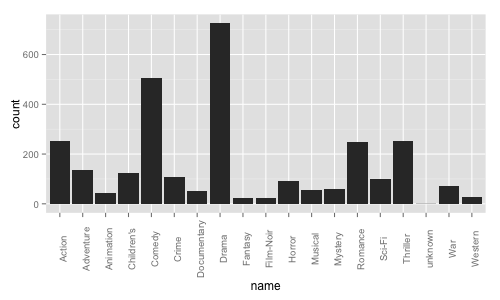

In [20]:
%%R -i genres_df -w 500 -h 300

ggplot(genres_df, aes(x=name, y=count)) + 
geom_bar(stat="identity") +
theme(axis.text.x = element_text(angle=90))

## Release date distribution

/Users/motta/.pyenv/versions/learning-to-rank/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


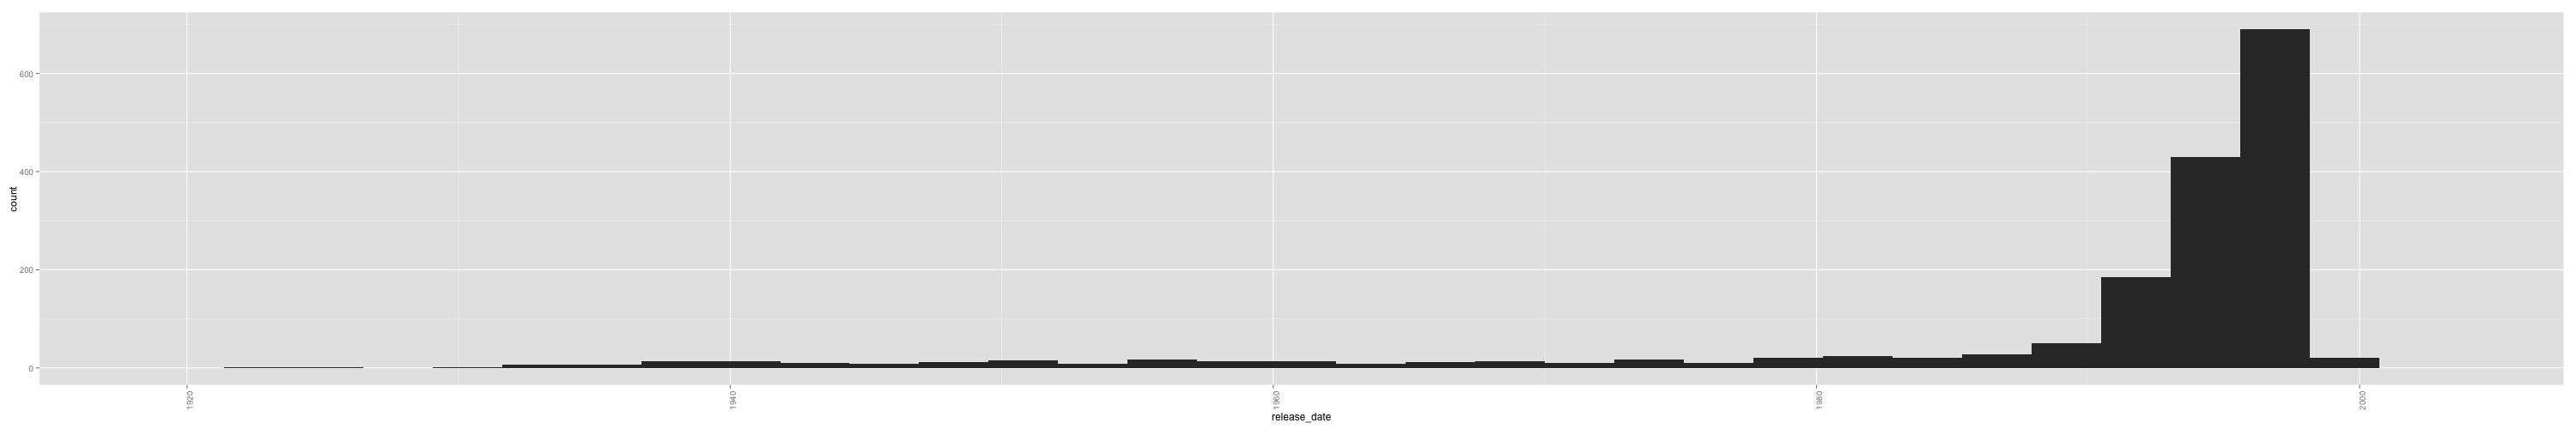

In [21]:
%%R -i movie_data -w 3000 -h 500

ggplot(movie_data, aes(x=release_date)) + 
geom_bar() +
theme(axis.text.x = element_text(angle=90))

## Ratings average distribution

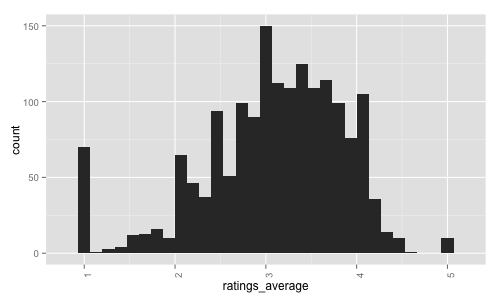

In [22]:
%%R -i movie_data -w 500 -h 300

ggplot(movie_data, aes(x=ratings_average)) + 
geom_bar() +
theme(axis.text.x = element_text(angle=90))

## Price

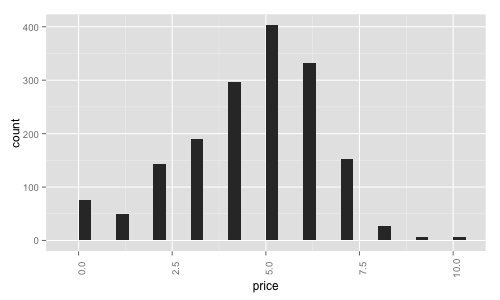

In [23]:
%%R -i movie_data -w 500 -h 300

ggplot(movie_data, aes(x=price)) + 
geom_bar() +
theme(axis.text.x = element_text(angle=90))

## Ratings count distribution

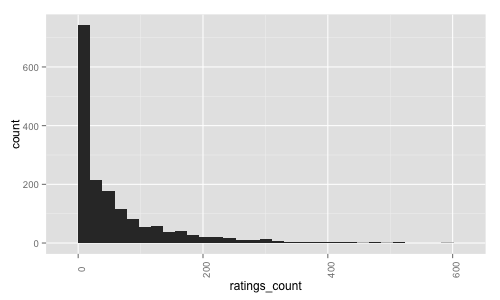

In [24]:
%%R -i movie_data -w 500 -h 300

ggplot(movie_data, aes(x=ratings_count)) + 
geom_bar() +
theme(axis.text.x = element_text(angle=90))

## Buy probability distribution

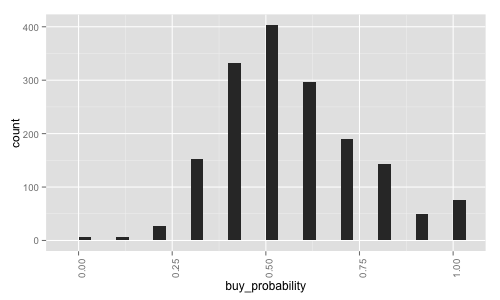

In [25]:
%%R -i movie_data -w 500 -h 300

ggplot(movie_data, aes(x=buy_probability)) + 
geom_bar() +
theme(axis.text.x = element_text(angle=90))

## Buy and Price relation

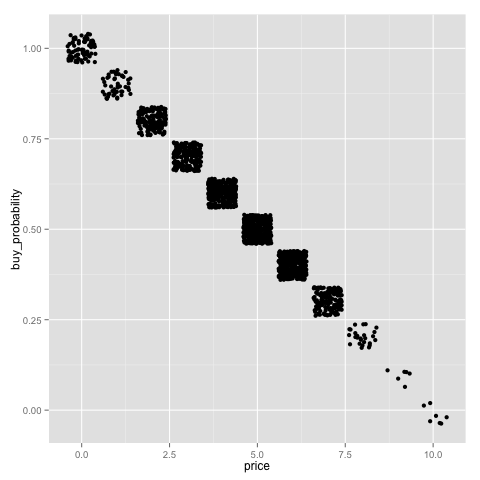

In [26]:
%%R -i movie_data
ggplot(movie_data, aes(x=price, y=buy_probability)) + geom_point(position = position_jitter())

# Events database

Each user has a certain probability of renting a movie. Let `X` the random variable being `1` if the user rented the movie and `0` otherwise.  

$$X \backsim Bernoulli(p)$$

where $p=f(movie~features)$.

In [27]:
np.random.seed(1)

In [28]:
# Saw a movie and ended up buying it
# [
#   user_1: [list of movies]
#   user_2: [list of movies]
#   ...
# ]
class PositiveEvents:
    def __init__(self):
        self.data = []
    
    def add(self, user_id, movie_id):
        self.data.append({'user_id': user_id, 'movie_id': movie_id})
    
    def all(self):
        return self.data

# Saw a movie but did not buy
# [
#   user_1: [list of movies]
#   user_2: [list of movies]
#   ...
# ]
class NegativeEvents:
    def __init__(self):
        self.data = []
        
    def add(self, user_id, movie_id):
        self.data.append({'user_id': user_id, 'movie_id': movie_id})
    
    def all(self):
        return self.data

# The users database
class Users:
    def __init__(self):
        self.data = []
        
    def add(self, user_id):
        self.data.append({'user_id': user_id})
    
    def all(self):
        return self.data

In [29]:
NUM_OF_OPENED_MOVIES_PER_USER = 20
NUM_OF_USERS = 20000

users = Users()
positive_events = PositiveEvents()
negative_events = NegativeEvents()

for id in range(1, NUM_OF_USERS):
    users.add(id)

for user in users.all():
    opened_movies = np.random.choice(movie_data.index.values, NUM_OF_OPENED_MOVIES_PER_USER)
    
    for movie_id in opened_movies:
        if np.random.binomial(1, movie_data.loc[movie_id].buy_probability): 
            positive_events.add(user['user_id'], movie_id)
        else:
            negative_events.add(user['user_id'], movie_id)

In [30]:
movie_data.shape

(1681, 25)

In [31]:
len(positive_events.all())

222185

In [32]:
len(negative_events.all())

177795

# Generates data for training/testing

In [33]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [34]:
movie_data.head(1)

,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_average,ratings_count,price,buy_probability
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,3.878319,452,7,0.3


In [35]:
feature_columns = np.setdiff1d(movie_data.columns, np.array(['title', 'buy_probability']))
feature_columns

array(['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'price', 'ratings_average', 'ratings_count', 'release_date',
       'unknown'], dtype=object)

In [36]:
learning_data = movie_data.loc[:, feature_columns]
learning_data.head(1)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Romance,Sci-Fi,Thriller,War,Western,price,ratings_average,ratings_count,release_date,unknown
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,7,3.878319,452,1995-01-01,0


In [37]:
scaler = StandardScaler()
learning_data.loc[:, ('price')] = scaler.fit_transform(learning_data[['price']])
learning_data['ratings_average'] = scaler.fit_transform(learning_data[['ratings_average']])
learning_data['ratings_count'] = scaler.fit_transform(learning_data[['ratings_count']])
learning_data['release_date'] = learning_data['release_date'].apply(lambda x: x.year)
learning_data['release_date'] = scaler.fit_transform(learning_data[['release_date']])

learning_data.head(1)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Romance,Sci-Fi,Thriller,War,Western,price,ratings_average,ratings_count,release_date,unknown
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1.344357,1.026718,4.883605,0.393978,0


# Create the events for learning

In [38]:
events_data = []

for event in positive_events.all():
    tmp = learning_data.loc[event['movie_id']].to_dict()
    tmp['outcome'] = 1
    events_data += [tmp]

for event in negative_events.all():
    tmp = learning_data.loc[event['movie_id']].to_dict()
    tmp['outcome'] = 0
    events_data += [tmp]

events_data = pd.DataFrame(events_data)
events_data.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Sci-Fi,Thriller,War,Western,outcome,price,ratings_average,ratings_count,release_date,unknown
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,-1.307443,-1.376422,-0.715191,0.534335,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,-2.368163,-2.655833,-0.727633,0.604514,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-0.246723,-0.459109,-0.080661,0.043084,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0.283637,0.069868,-0.453914,0.253620,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,-0.777083,1.108383,0.765380,-2.483349,0


In [39]:
for genre in genres_data['name'].values:
    events_data[genre] = events_data[genre].astype(int)
    
events_data.dtypes

Action               int64
Adventure            int64
Animation            int64
Children's           int64
Comedy               int64
Crime                int64
Documentary          int64
Drama                int64
Fantasy              int64
Film-Noir            int64
Horror               int64
Musical              int64
Mystery              int64
Romance              int64
Sci-Fi               int64
Thriller             int64
War                  int64
Western              int64
outcome              int64
price              float64
ratings_average    float64
ratings_count      float64
release_date       float64
unknown              int64
dtype: object

# Events distributions

In [40]:
events_data_sample = events_data.sample(frac=0.1)

/Users/motta/.pyenv/versions/learning-to-rank/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


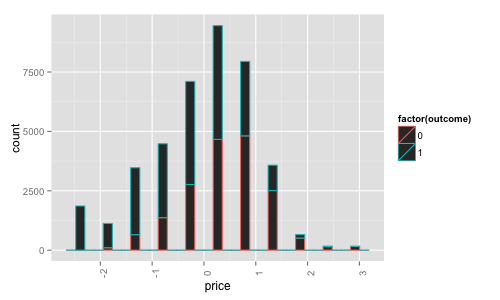

In [41]:
%%R -i events_data_sample -w 500 -h 300

ggplot(events_data_sample, aes(x=price, color=factor(outcome))) + 
geom_bar() +
theme(axis.text.x = element_text(angle=90))

# Save events to CSV for external processing

In [42]:
events_data = events_data.reindex(np.random.permutation(events_data.index))
events_data.to_csv('movie_events.csv')

# Train/Test data split

In [38]:
X = events_data.loc[:, feature_columns].values
print('overall input shape: ' + str(X.shape))

y = events_data.loc[:, ['outcome']].values.ravel()
print('overall output shape: ' + str(y.shape))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('training input shape: ' + str(X_train.shape))
print('training output shape: ' + str(y_train.shape))

print('testing input shape: ' + str(X_test.shape))
print('testing output shape: ' + str(y_test.shape))

overall input shape: (399980, 23)
overall output shape: (399980,)
training input shape: (319984, 23)
training output shape: (319984,)
testing input shape: (79996, 23)
testing output shape: (79996,)


# Ranking with Amazon ML

![title](amazon_performance.png)

# The perfect predictor

In [105]:
class PerfectPredictor:
    def __init__(self, prices):
        price = X_train[:, -5]
        max_price = np.max(prices)
        min_price = np.min(prices)

        self.norm_prices = [ (x - min_price)/(max_price - min_price) for x in prices ]
    
    def predict(self, X):
        return [self.predict_one(i, x) for i, x in enumerate(X)]
            
    def predict_one(self, i, x):
        if self.norm_prices[i] > 0.5:
            return 1
        else:
            return 0

In [106]:
p = PerfectPredictor(X_train[:, -5])

In [107]:
y_train_pred = p.predict(X_train)

print('train precision: ' + str(precision_score(y_train, y_train_pred)))
print('train recall: ' + str(recall_score(y_train, y_train_pred)))
print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))

train precision: 0.351595983815
train recall: 0.198007156682
train accuracy: 0.351701960098


In [108]:
y_test_pred = p.predict(X_test)

print('test precision: ' + str(precision_score(y_test, y_test_pred)))
print('test recall: ' + str(recall_score(y_test, y_test_pred)))
print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))

test precision: 0.552117329465
test recall: 0.308285900695
test accuracy: 0.476698834942


# Rank with a Logistic Regression

* Collect for each movie the buy probability from the raw events
* Run a beta regression

=> Expect the coefficients to represent the artificial probability function

In [39]:
l = LogisticRegression()
l.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
y_train_pred = l.predict(X_train)

print('train precision: ' + str(precision_score(y_train, y_train_pred)))
print('train recall: ' + str(recall_score(y_train, y_train_pred)))
print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))

train precision: 0.665267528143
train recall: 0.737470180492
train accuracy: 0.648069903495


In [41]:
y_test_pred = l.predict(X_test)

print('test precision: ' + str(precision_score(y_test, y_test_pred)))
print('test recall: ' + str(recall_score(y_test, y_test_pred)))
print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))

test precision: 0.66292225798
test recall: 0.736866971135
test accuracy: 0.645607280364


# Rank with a Neural Network

* Input each event to the Neural network
* Train the network
* Run the prediction on the training set

=> Expect the order of the results to represent the artificial probability function

In [42]:
import logging
fh = logging.FileHandler('output.log')

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.removeHandler(logger.handlers[0])
logger.addHandler(fh)

In [44]:
from sknn.mlp import Classifier, Layer

nn = Classifier(
    layers=[
        Layer("Sigmoid", units=feature_columns.size),
        Layer("Softmax")],
    learning_rate=0.1,
    n_iter=20)

nn.fit(X_train, y_train)

Classifier(batch_size=1, callback=None, debug=False, dropout_rate=None,
      f_stable=0.001,
      hidden0=<sknn.nn.Layer `Sigmoid`: units=23, frozen=False, name='hidden0'>,
      layers=[<sknn.nn.Layer `Sigmoid`: units=23, frozen=False, name='hidden0'>, <sknn.nn.Layer `Softmax`: units=2, frozen=False, name='output'>],
      learning_momentum=0.9, learning_rate=0.1, learning_rule='sgd',
      loss_type=None, n_iter=20, n_stable=10, normalize=None,
      output=<sknn.nn.Layer `Softmax`: units=2, frozen=False, name='output'>,
      parameters=None, random_state=None, regularize=None, valid_set=None,
      valid_size=0.0, verbose=None, warning=None, weight_decay=None)

In [45]:
y_train_pred = nn.predict(X_train)

print('train precision: ' + str(precision_score(y_train, y_train_pred)))
print('train recall: ' + str(recall_score(y_train, y_train_pred)))
print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))

[(319984, 2)]
train precision: 0.599829332786
train recall: 0.921484673898
train accuracy: 0.614918245912


In [46]:
y_test_pred = nn.predict(X_test)

print('test precision: ' + str(precision_score(y_test, y_test_pred)))
print('test recall: ' + str(recall_score(y_test, y_test_pred)))
print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))

[(79996, 2)]
test precision: 0.598877406341
test recall: 0.921753020315
test accuracy: 0.613480674034


# FANN

In [59]:
from fann2 import libfann

In [60]:
ann = libfann.neural_net()

In [61]:
ann.create_standard_array([feature_columns.size, feature_columns.size, 1])

True

In [62]:
fann_data = libfann.training_data()

In [63]:
fann_y_train = [[y] for y in y_train]

In [64]:
fann_data.set_train_data(X_train, fann_y_train)
ann.train_on_data(fann_data, 100, 1, 0.001)

In [65]:
def get_predictions_for(ann, x):
    y_pred = []
    for i in x:
        y_pred.append(np.argmax(ann.run(i)))

    return np.array(y_pred)

In [66]:
y_train = np.array(fann_y_train).ravel()
y_train_pred = get_predictions_for(ann, X_train)

print('train precision: ' + str(precision_score(y_train, y_train_pred)))
print('train recall: ' + str(recall_score(y_train, y_train_pred)))
print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))

train precision: 0.0
train recall: 0.0
train accuracy: 0.444547227361


/Users/motta/.pyenv/versions/learning-to-rank/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
y_train_pred

array([0, 0, 0, ..., 0, 0, 0])

In [58]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

# Neural Network on the cloud

Setup on MacOSx
https://gist.github.com/ageitgey/819a51afa4613649bd18

Setup on AWS
https://github.com/Avsecz/aws-tensorflow-setup

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/multilayer_perceptron.ipynb